Data: http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/

https://sci2s.ugr.es/keel/dataset.php?cod=113

* Thinking of a problem that's interesting for you and finding a dataset for that
* Describing this problem and explaining how a model could be used
* Preparing the data and doing EDA, analyzing important features
* Training multiple models, tuning their performance and selecting the best model
* Exporting the notebook into a script
* Putting your model into a web service and deploying it locally with docker
* Bonus points for deploying the service to the cloud

In [764]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 200)
from statistics import mean


In [734]:
df = pd.read_csv('vowels_data.csv')

In [735]:
df.drop(columns = "train_test", inplace = True)

In [740]:
df_test = df[df.speaker.isin([10, 11, 13, 14])]  # Two male and two female in df_test

In [748]:
df_train = df[df.speaker.isin([0,1,2,3,4,5,6,7,8,9,12])]
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [845]:
df_train.head()

,speaker,sex,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,vowel
0,5,1,-2.511,1.511,-0.555,0.226,-0.735,0.631,-0.006,0.520,-0.138,-0.651,5
1,2,0,-1.280,0.798,-1.647,0.968,-0.418,1.609,-0.031,1.224,-0.374,0.044,2
2,3,0,-2.030,1.764,-0.386,-0.249,0.180,0.117,0.096,-0.121,0.067,-0.552,3
3,6,1,-2.210,0.661,-0.581,1.139,0.238,0.074,-0.625,-0.366,-0.326,0.557,2
4,9,0,-4.101,2.840,-0.802,0.062,-0.733,1.304,-0.145,0.443,0.049,-0.611,8


In [846]:
df_train.dtypes

speaker      int64
sex          int64
f0         float64
f1         float64
f2         float64
f3         float64
f4         float64
f5         float64
f6         float64
f7         float64
f8         float64
f9         float64
vowel        int64
dtype: object

It's tricky to know how to split the data for train/val/test. Although I have 990 rows of data, they are only spoken by 15 people, and it is reasonable to think that the person speaking is likely to have a significant impact on the data.

If I were to split the 990 rows randomly, I would have data leakage from the test data into the training data, since some of the training data would come from the same people who also produced test data.

Therefore I decided to split off the test data according to people. I chose two male and two female speakers to constitute the test data.

I considered whether or not I should take a similar approach for the validation data. In the end I decided to use a manual cross-validation, where I held back one person from the training data each time to be used for validation, and then took the mean of the evaluation metrics.

## Missing Values

In [844]:
df_train.isnull().sum()

speaker    0
sex        0
f0         0
f1         0
f2         0
f3         0
f4         0
f5         0
f6         0
f7         0
f8         0
f9         0
vowel      0
dtype: int64

## Exploration of features

<AxesSubplot:>

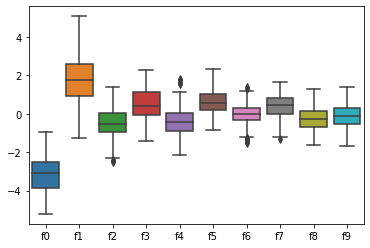

In [841]:
sns.boxplot(data = df_train[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']])

We need to shuffle the rows, because they're currently in speaker and vowel order.

## Build and test some initial models

In [707]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [795]:
def evaluate_model(model, df_train = df_train):
    speakers = df_train['speaker'].unique()
    scores = []
    for speaker in speakers:
        df_train = df_train.copy()
        X_train = df_train[df_train['speaker'] != speaker]
        X_val = df_train[df_train['speaker'] == speaker]
        y_train = df_train.loc[df_train['speaker'] != speaker]['vowel']
        y_val = df_train.loc[df_train['speaker'] == speaker]['vowel']
        model.fit(X_train.loc[:, X_train.columns != 'vowel'], y_train)
        y_preds = model.predict_proba(X_val.loc[:, X_val.columns != 'vowel'])
        scores.append(roc_auc_score(y_val, y_preds, multi_class='ovo'))
#     print(f'Scores: {scores}\nMean: {mean(scores)}')
    return mean(scores)

In [804]:
lr = LogisticRegression(multi_class="multinomial", solver='saga')
print(f'AUC: {evaluate_model(lr)}')

/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The m

AUC = 0.8974977043158863


/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [803]:
rf = RandomForestClassifier()
print(f'AUC: {evaluate_model(rf)}')

AUC = 0.9412993572084482


In [805]:
gb = GradientBoostingClassifier()
print(f'AUC: {evaluate_model(gb)}')

AUC = 0.8926078971533516


## Tuning Hyperparameters

### Random Forest

In [810]:
n_estimators_list = [25, 50, 100, 200, 400, 800, 1600]

In [809]:
for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n)
    print(f'n_esimators: {n} \t AUC: {evaluate_model(rf)}')

n_esimators: 25, 	 AUC: 0.9179866850321396
n_esimators: 50, 	 AUC: 0.9319214876033058
n_esimators: 100, 	 AUC: 0.9462350780532599


In [815]:
max_depth_list = [10, 15, 20, 30, 50]

In [816]:
for m in max_depth_list:
    rf = RandomForestClassifier(n_estimators=400, max_depth=m)
    print(f'max_depth: {m} \t AUC: {evaluate_model(rf)}')

max_depth: 10 	 AUC: 0.948014233241506
max_depth: 15 	 AUC: 0.951848025711662
max_depth: 20 	 AUC: 0.9483815426997245
max_depth: 30 	 AUC: 0.9495867768595042
max_depth: 50 	 AUC: 0.951320018365473


In [ ]:
for m in max_depth_list:
    rf = RandomForestClassifier(n_estimators=400, max_depth=15,)
    print(f'max_depth: {m} \t AUC: {evaluate_model(rf)}')

In [822]:
dir(rf)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 'bootstrap',
 'ccp_alpha',
 'class_weight',
 'classes_',
 'criterion',
 'decision_path',
 'estimator_params',
 'estimators_',
 'feature_

In [840]:
rf.estimators_

[DecisionTreeClassifier(max_depth=50, max_features='auto',
                        random_state=192646646),
 DecisionTreeClassifier(max_depth=50, max_features='auto',
                        random_state=506595718),
 DecisionTreeClassifier(max_depth=50, max_features='auto',
                        random_state=1538643611),
 DecisionTreeClassifier(max_depth=50, max_features='auto',
                        random_state=766261314),
 DecisionTreeClassifier(max_depth=50, max_features='auto',
                        random_state=1071640796),
 DecisionTreeClassifier(max_depth=50, max_features='auto',
                        random_state=749713869),
 DecisionTreeClassifier(max_depth=50, max_features='auto', random_state=86556380),
 DecisionTreeClassifier(max_depth=50, max_features='auto',
                        random_state=249653386),
 DecisionTreeClassifier(max_depth=50, max_features='auto',
                        random_state=1939484071),
 DecisionTreeClassifier(max_depth=50, max_features